In [1]:
# Import packages
import os
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

sys.path.insert(0, os.path.join(os.getcwd(), '..'))
import utilities
from utilities import geography_utils

In [2]:
# We want to look at the continental US only.
# These will help us identify valid entries,
# if only latitude/longitude are available

latitude_bounds = [23.731583, 49.996020]
longitude_bounds = [-127.375204, -65.024923]

In [3]:
chargers = pd.read_csv('superchargers.csv')
chargers = chargers.loc[~chargers['state'].isin(['PR'])]
chargers.head(3)

,name,address,city,state,zip,country,num_stalls,power,lat_lon,elevation,status,open_date
0,"Miami - South Dixie Highway, FL",8312 Dixie Highway,Miami,FL,33143,USA,12,72.0,"25.693198, -80.304898",3,OPEN,2020-06-11
1,"Mackinaw City, MI",801 S Huron Ave,Mackinaw City,MI,49701,USA,8,250.0,"45.77225, -84.7265",180,OPEN,2020-06-10
2,"Hermosa Beach, CA",710 16th St,Hermosa Beach,CA,90254,USA,20,250.0,"33.864955, -118.394819",25,OPEN,2020-06-10


In [4]:
# Clean up the lat/lon data
chargers[['lat', 'lon']] = chargers['lat_lon'].str.split(expand=True)
chargers['lat'] = chargers['lat'].apply(lambda x: x.replace(',','')).astype(float)
chargers['lon'] = chargers['lon'].apply(lambda x: x.replace(',','')).astype(float)
chargers = chargers.drop(columns=['lat_lon'])

Text(0.5, 1.0, 'Number of Supercharging Stations Per State')

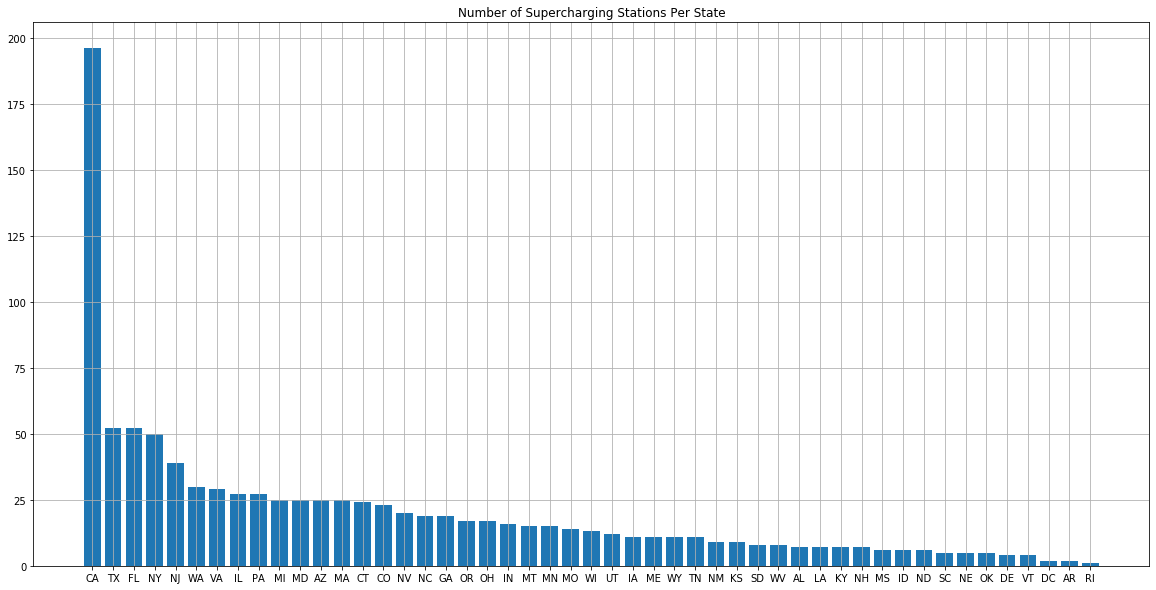

In [5]:
# States with the most chargering stations available
fig, ax = plt.subplots(figsize=(20,10))
stations_per_state = chargers.groupby('state')['name'].count().sort_values(ascending=False)
ax.bar(stations_per_state.index, stations_per_state.values)
ax.grid()
ax.set_title('Number of Supercharging Stations Per State')

Text(0.5, 1.0, 'Number of Supercharging Stalls Per State')

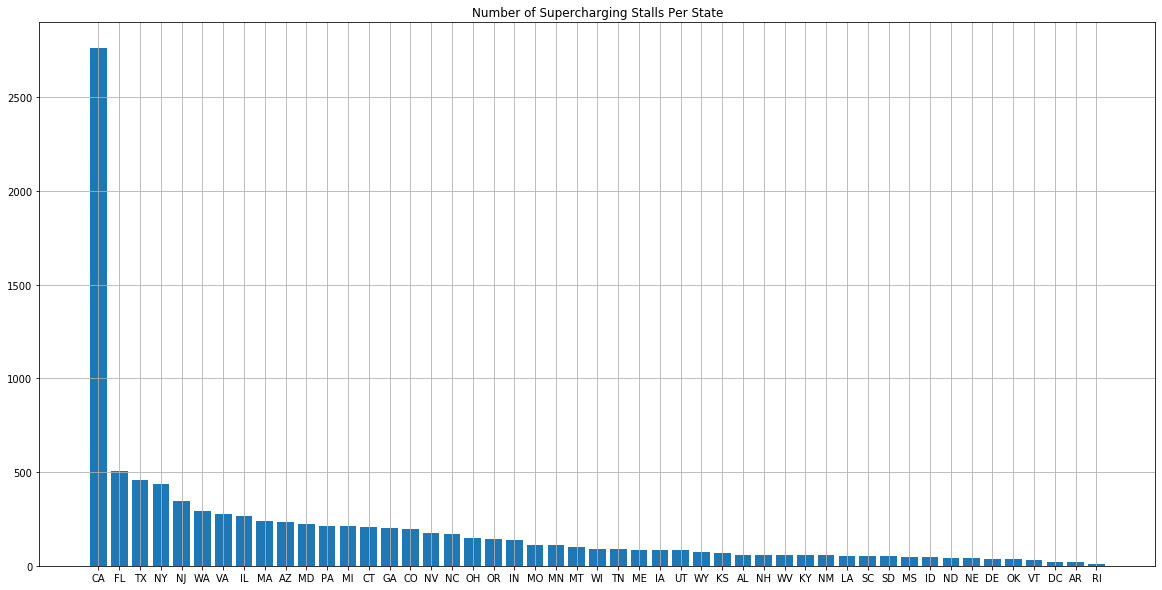

In [6]:
# States with the most charging stalls available
fig, ax = plt.subplots(figsize=(20,10))
stalls_per_state = chargers.groupby('state')['num_stalls'].sum().sort_values(ascending=False)
ax.bar(stalls_per_state.index, stalls_per_state.values)
ax.grid()
ax.set_title('Number of Supercharging Stalls Per State')

In [7]:
# Read in state shapes
state_shape = gpd.read_file('../../../../data/geometry/states/cb_2018_us_state_500k.shp')
# Merge with stations per state
state_chargers = state_shape.rename(columns={'STUSPS':'state'}).merge(
    stations_per_state.to_frame(name='num_stations'), on=['state'])
state_chargers = state_chargers.loc[~state_chargers['state'].isin(['PR'])]
state_chargers.head(3)

,STATEFP,STATENS,AFFGEOID,GEOID,state,NAME,LSAD,ALAND,AWATER,geometry,num_stations
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ...",6
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ...",19
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6...",5


In [8]:
# We will need to do some location extraction from the highways to limit to the continental US
def is_within_latitude_longitude(lineshape):
    
    centroid_lon = lineshape.centroid.x
    centroid_lat = lineshape.centroid.y
    
    return ((centroid_lon > min(longitude_bounds)) &
            (centroid_lon < max(longitude_bounds)) &
            (centroid_lat > min(latitude_bounds)) &
            (centroid_lat < max(latitude_bounds)))

In [9]:
# Read in major us highway shapes
highways = gpd.read_file('../../../../data/geometry/highways/tl_2016_us_primaryroads.shp')

#Filter out non-continental states
highways['continental_loc'] = highways['geometry'].apply(is_within_latitude_longitude)
highways = highways.loc[highways['continental_loc']].reset_index(drop=True)

In [10]:
# Add geometry of all charger locations
chargers = gpd.GeoDataFrame(chargers, geometry=gpd.points_from_xy(chargers['lon'], chargers['lat']))
chargers.head(3)

,name,address,city,state,zip,country,num_stalls,power,elevation,status,open_date,lat,lon,geometry
0,"Miami - South Dixie Highway, FL",8312 Dixie Highway,Miami,FL,33143,USA,12,72.0,3,OPEN,2020-06-11,25.693198,-80.304898,POINT (-80.30490 25.69320)
1,"Mackinaw City, MI",801 S Huron Ave,Mackinaw City,MI,49701,USA,8,250.0,180,OPEN,2020-06-10,45.772250,-84.726500,POINT (-84.72650 45.77225)
2,"Hermosa Beach, CA",710 16th St,Hermosa Beach,CA,90254,USA,20,250.0,25,OPEN,2020-06-10,33.864955,-118.394819,POINT (-118.39482 33.86496)


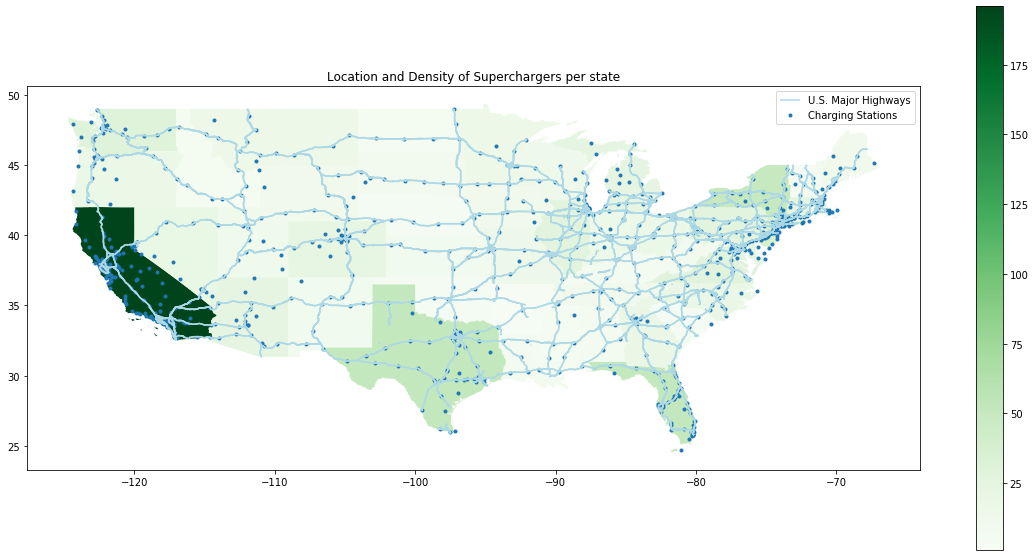

In [11]:
fig, ax = plt.subplots(figsize=(20,10))
state_chargers.plot(ax=ax, column='num_stations', cmap='Greens', legend=True)
highways.plot(ax=ax, color='lightblue', label='U.S. Major Highways')
chargers.plot(ax=ax, marker='.', label='Charging Stations')
ax.set_title('Location and Density of Superchargers per state')
ax.legend()

In [12]:
# Create tables with raw lat/lon values
highway_ll = geography_utils.linestrings_to_df(highways['geometry'])

In [ ]:
# Find the distance of each highway point to the closest supercharger location
dist_to_sc, i_to_sc = geography_utils.find_closest_ll(highway_ll, chargers.rename(columns={'lon':'longitude',
                                                                                                    'lat':'latitude'}))
highway_ll['distance_to_closest_charger'] = dist_to_sc

In [ ]:
# Create geopandas dataframe from the 
highway_worst_10 = highway_ll.sort_values(on='distance_to_closest_charger').head(10)
highway_geo = gpd.GeoDataFrame(highway_worst_10, geometry=gpd.points_from_xy(
    highway_worst_10['longitude'], highway_worst_10['latitude']))

fig, ax = plt.subplots(figsize=(20,10))
state_chargers.plot(ax=ax, column='num_stations', cmap='Greens', legend=True)
highway_geo.plot(ax=ax, marker='.')